In [1]:
import numpy as np
import pandas as pd
import os
import shutil
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.metrics import classification_report, log_loss, accuracy_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import random
from tensorflow.keras.models import Model
import seaborn as sns

In [2]:
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

import matplotlib.image as img
import itertools
import pathlib
import warnings
import time
import gc
from IPython.display import Markdown, display
from PIL import Image

warnings.filterwarnings('ignore')

In [3]:
def load_images_from_folder(folder, only_path=False, label=None):
    images = []
    if only_path:
        if os.path.isfile(folder):
            return [(label, folder)]  # Return the single image path with its corresponding label
    else:
        path = []
        for filename in os.listdir(folder):
            img_path = os.path.join(folder, filename)
            if os.path.isfile(img_path):  # Check if the path is a file
                if only_path:
                    path.append(img_path)
                else:
                    images.append((label, img_path))
        if only_path:
            return path  # Return the list of image paths
    return images  # Return the list of image labels and paths

# Specify the directory path
directory = "/kaggle/input/mst-dataset/mst_data/"

# Load images from folders and create a list of (label, path) tuples
images = []
for f in os.listdir(directory):
    if os.path.isdir(directory + f):
        for d in os.listdir(directory + f):
            images += load_images_from_folder(os.path.join(directory, f, d), True, label=f)

# Create a DataFrame from the list of tuples
df = pd.DataFrame(images, columns=["skintones", "path"])

# Shuffle the DataFrame if desired
df = df.sample(frac=1).reset_index(drop=True)
print(df)

     skintones                                               path
0      Class_7  /kaggle/input/mst-dataset/mst_data/Class_7/PXL...
1      Class_8  /kaggle/input/mst-dataset/mst_data/Class_8/PXL...
2      Class_8  /kaggle/input/mst-dataset/mst_data/Class_8/PXL...
3      Class_1  /kaggle/input/mst-dataset/mst_data/Class_1/PXL...
4      Class_2  /kaggle/input/mst-dataset/mst_data/Class_2/PXL...
...        ...                                                ...
1376  Class_10  /kaggle/input/mst-dataset/mst_data/Class_10/PX...
1377   Class_6  /kaggle/input/mst-dataset/mst_data/Class_6/PXL...
1378   Class_9  /kaggle/input/mst-dataset/mst_data/Class_9/PXL...
1379   Class_2  /kaggle/input/mst-dataset/mst_data/Class_2/PXL...
1380   Class_7  /kaggle/input/mst-dataset/mst_data/Class_7/PXL...

[1381 rows x 2 columns]


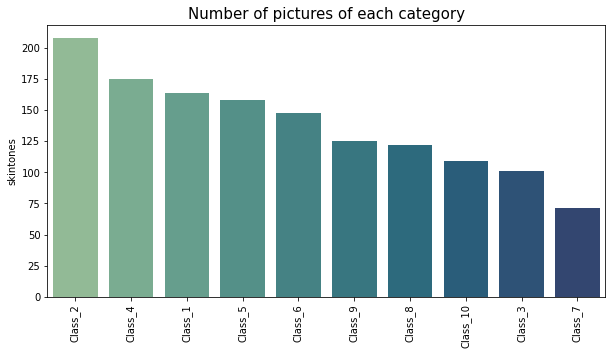

In [4]:
import seaborn as sns
fc = df["skintones"].value_counts()
plt.figure(figsize=(10,5))
sns.barplot(x = fc.index, y = fc, palette = "crest")
plt.title("Number of pictures of each category", fontsize = 15)
plt.xticks(rotation=90)
plt.show()

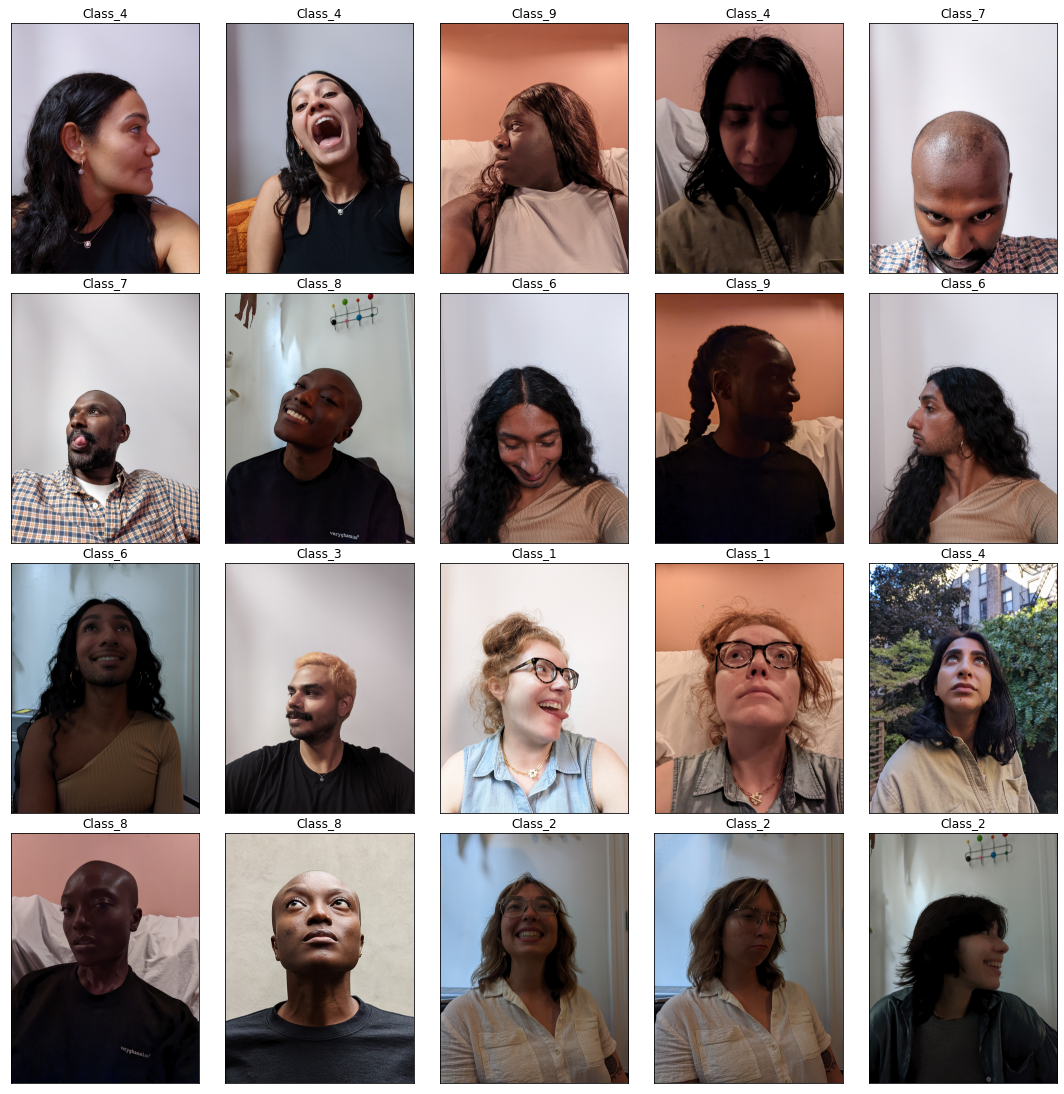

In [5]:
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.path[i+20]))
    ax.set_title(df.skintones[i+20], fontsize = 12)
plt.tight_layout(pad=0.0)
plt.show()

In [60]:
def extractSkin(image):
  # Taking a copy of the image
  img =  image.copy()
  # Converting from BGR Colours Space to HSV
  img =  cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
  
  # Defining HSV Threadholds
  lowerThreshold = np.array([0, 48, 80], dtype=np.uint8)
  upperThreshold = np.array([20, 255, 255], dtype=np.uint8)
  
  # Single Channel mask,denoting presence of colours in the about threshold
  skinMask = cv2.inRange(img,lowerThreshold,upperThreshold)
  
  # Cleaning up mask using Gaussian Filter
  skinMask = cv2.GaussianBlur(skinMask,(3,3),0)
  
  # Apply a series of erosions and dilations to the mask using an elliptical kernel
  kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
  skinMask = cv2.dilate(skinMask, kernel, iterations = 2)

  # Extracting skin from the threshold mask
  skin  =  cv2.bitwise_and(img,img,mask=skinMask)

  # Return the Skin image
  return cv2.cvtColor(skin,cv2.COLOR_HSV2BGR)

In [61]:
# Load and preprocess images
images = []
for image_path in df["path"]:
    image = plt.imread(image_path)
    image = cv2.resize(image, (224, 224))
    image = extractSkin(image)
    image_array = img_to_array(image)
    image_array = image_array / 255.0  # Normalize pixel values
    images.append(image_array)
X = np.array(images)

In [62]:
# Convert labels to categorical values
y = pd.get_dummies(df["skintones"]).values
print(y)

[[0 0 0 ... 1 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 1 0]
 ...
 [0 0 0 ... 0 0 1]
 [0 0 1 ... 0 0 0]
 [0 0 0 ... 1 0 0]]


In [63]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Model Architecture

In [64]:
from tensorflow.keras.applications import ResNet50, DenseNet201, Xception, InceptionV3, VGG19, MobileNet

In [65]:
pretrained_model = MobileNet(input_shape=(224, 224, 3), include_top=False, weights='imagenet', pooling='avg')
pretrained_model.trainable = False

In [67]:
from tensorflow.keras.layers import LeakyReLU

inputs3 = pretrained_model.input
x3 = tf.keras.layers.Dense(128)(pretrained_model.output)
x3 = LeakyReLU(alpha=0.1)(x3)  # Menggunakan LeakyReLU dengan alpha=0.1
x3 = tf.keras.layers.BatchNormalization()(x3)
x3 = tf.keras.layers.Dropout(0.5)(x3)
x3 = tf.keras.layers.Dense(64)(x3)
x3 = LeakyReLU(alpha=0.1)(x3)
x3 = tf.keras.layers.BatchNormalization()(x3)
x3 = tf.keras.layers.Dropout(0.3)(x3)
outputs3 = tf.keras.layers.Dense(10, activation='softmax')(x3)
model = tf.keras.Model(inputs=inputs3, outputs=outputs3)

In [68]:
!pip install visualkeras

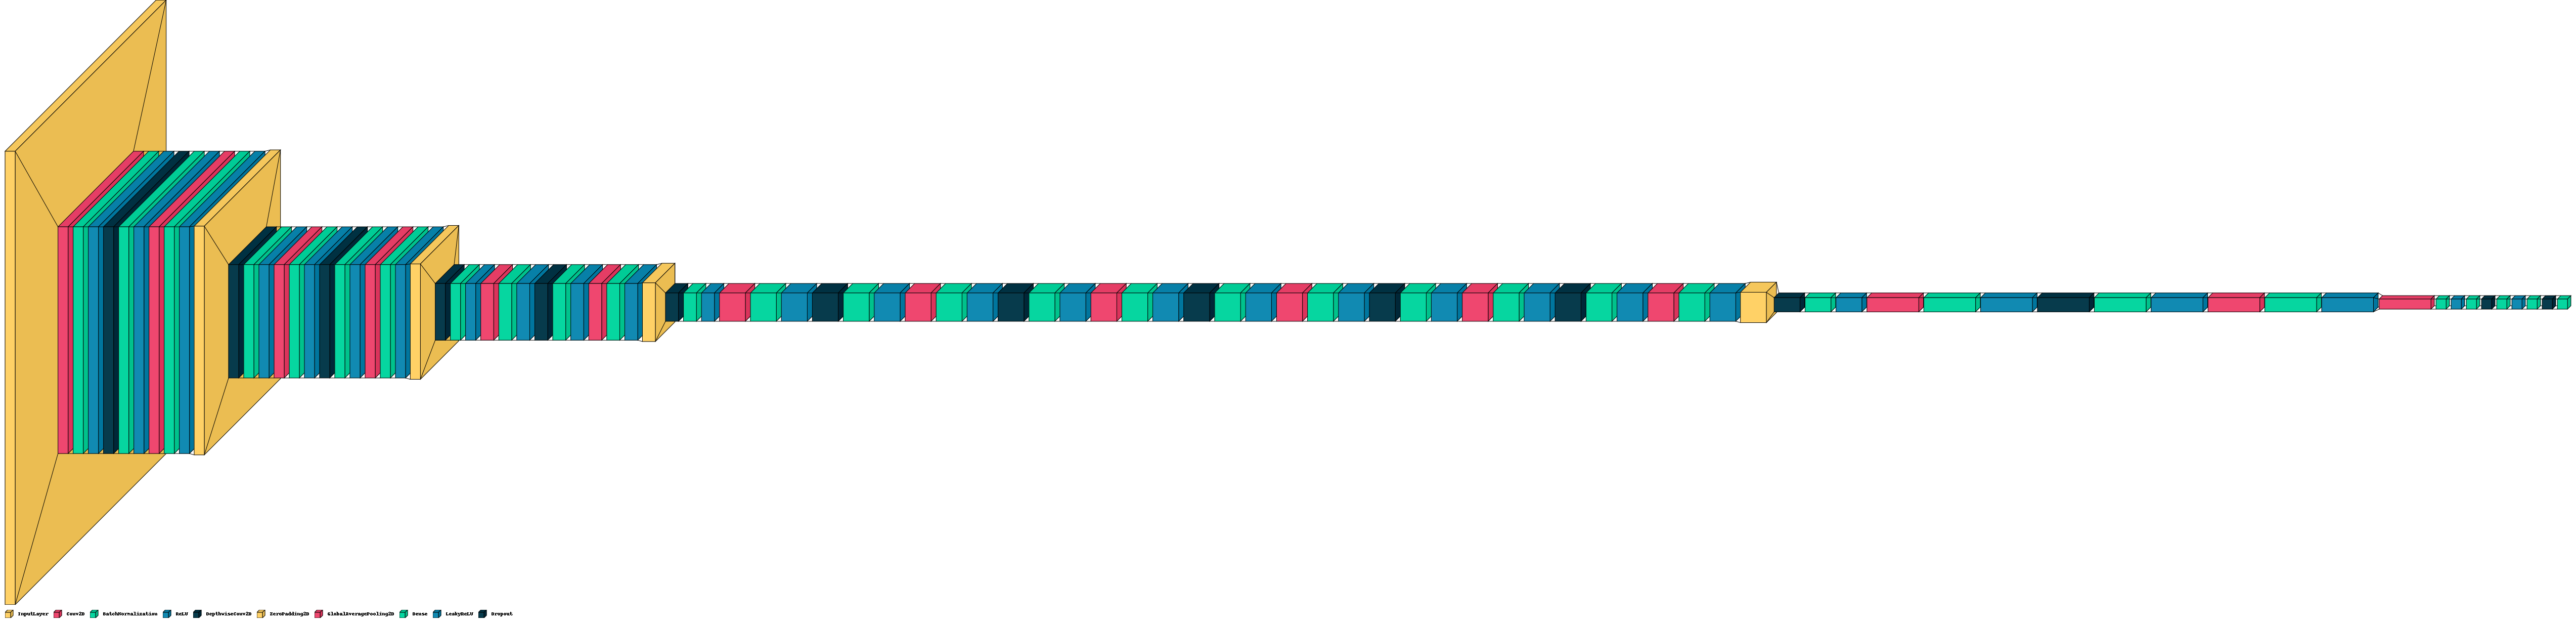

In [69]:
import visualkeras
visualkeras.layered_view(model, legend=True) 

In [70]:
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0   

# optim Nadam

In [71]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# optim Adagrad

In [72]:
# optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
# model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [73]:
# Callback early stopping
early_stopping = EarlyStopping(monitor='train_acc', patience=15, restore_best_weights=True)

# Training model with early stopping
model.fit(X_train, y_train, batch_size=32, epochs=200, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/200
31/31 [==============================] - 4s 66ms/step - loss: 2.5808 - accuracy: 0.2012 - val_loss: 1.6948 - val_accuracy: 0.4337
Epoch 2/200
31/31 [==============================] - 1s 42ms/step - loss: 1.7699 - accuracy: 0.4119 - val_loss: 1.4652 - val_accuracy: 0.4602
Epoch 3/200
31/31 [==============================] - 1s 42ms/step - loss: 1.5119 - accuracy: 0.5058 - val_loss: 1.3253 - val_accuracy: 0.5566
Epoch 4/200
31/31 [==============================] - 1s 42ms/step - loss: 1.2847 - accuracy: 0.5579 - val_loss: 1.2277 - val_accuracy: 0.5880
Epoch 5/200
31/31 [==============================] - 1s 42ms/step - loss: 1.2093 - accuracy: 0.5922 - val_loss: 1.1624 - val_accuracy: 0.6289
Epoch 6/200
31/31 [==============================] - 1s 42ms/step - loss: 1.1959 - accuracy: 0.6080 - val_loss: 1.0973 - val_accuracy: 0.6361
Epoch 7/200
31/31 [==============================] - 1s 43ms/step - loss: 1.1479 - accuracy: 0.6198 - val_loss: 1.0675 - val_accuracy: 0.6361
Epoch 

In [74]:
labels = ['Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_5', 'Class_6', 'Class_7', 'Class_8', 'Class_9', 'Class_10']

# Predict the values from the validation dataset
y_pred = model.predict(X_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis=1)
# Convert validation observations to one hot vectors
y_true = np.argmax(y_test, axis=1)
print(classification_report(y_true, y_pred_classes, target_names=labels))

              precision    recall  f1-score   support

     Class_1       0.38      0.94      0.54        51
     Class_2       0.79      0.54      0.64        28
     Class_3       0.73      0.59      0.65        61
     Class_4       1.00      0.70      0.83        37
     Class_5       0.89      0.67      0.76        58
     Class_6       0.97      0.90      0.94        40
     Class_7       0.86      0.69      0.77        45
     Class_8       1.00      1.00      1.00        27
     Class_9       0.77      0.66      0.71        35
    Class_10       0.85      0.52      0.64        33

    accuracy                           0.72       415
   macro avg       0.82      0.72      0.75       415
weighted avg       0.81      0.72      0.73       415



In [75]:
# # Menyimpan model ke file .h5
# model.save('modelMobileNetLayerbAjaNADAMLeakyReluoptim.h5')